# CALC log analysis

The following notebook assumes you have downloaded the CALC logs as CSV from [api.data.gov/admin](https://api.data.gov/admin/) and saved them as `logs.csv` in the same directory as this notebook.

We'll start by importing our prerequisites and defining some constants.

In [1]:
%matplotlib inline

import pandas
import warnings
from pandas.io.pytables import PerformanceWarning

warnings.simplefilter(action='ignore', category=PerformanceWarning)

RATES_URL = 'https://api.data.gov/gsa/calc/rates/'

FIELD_DEFAULTS = {
    'Search terms': '',
    'Minimum experience': 0,
    'Maximum experience': 45,
    'Education level': '',
    'Worksite': '',
    'Business size': '',
    'Schedule': '',
    'Contract year': 'current',
    'Proposed price': '',
    'Query type': 'match_all',
    'Sort': 'current_price',
    'Rows excluded': 0,
}

## Parsing the logs

This is going to take a while, but we'll save the results in a [`HDFStore`](http://pandas.pydata.org/pandas-docs/stable/io.html#hdf5-pytables) at the end so that we can easily load our results from disk next time. If you've already parsed the logs in a previous session, you can skip to the [Loading the parsed logs](#Loading-the-parsed-logs) section below.

In [22]:
rows = pandas.read_csv('logs.csv', nrows=None, index_col=False, usecols=[
    'Time',
    'Method',
    'URL',
    'State',
    'Country',
    'City',
    'Status',
    'IP Address',
])

The following step is optional; we're removing identical requests coming from the same IP address. This might not actually be a great idea, especially if multiple actual users are behind the same IP address.

In [3]:
rows.drop_duplicates(subset=['Method', 'URL', 'IP Address'], inplace=True)

Now we'll filter only successful requests to the `/rates/` endpoint, which is the one used when users click the **Search** button (or initially load the page). We'll also parse the query string and add new columns that represent information about the search criteria.

In [4]:
from urllib.parse import urlparse, parse_qsl

rates = rows
rates = rates[rates['Method'] == 'GET']
rates = rates[rates['Status'] == 200]
rates = rates[rates['URL'].str.startswith(RATES_URL)]
rates['Time'] = rates['Time'].apply(pandas.to_datetime)

del rates['Method']
del rates['Status']

Here we're going to parse out all the query string arguments into their own separate `DataFrame`, which could take a while.

In [5]:
queries = rates['URL'].apply(
    lambda url: dict(parse_qsl(urlparse(url).query))
).apply(pandas.Series)

Now we'll marge the query string information with the original `DataFrame` and apply some default values.

In [34]:
rates['Search terms'] = queries['q'].str.lower().str.strip().str.replace(r',[ ]*$', '')
rates['Minimum experience'] = queries['min_experience'].apply(pandas.to_numeric)
rates['Maximum experience'] = queries['max_experience'].apply(pandas.to_numeric)
rates['Education level'] = queries['education']
rates['Worksite'] = queries['site']
rates['Business size'] = queries['business_size']
rates['Schedule'] = queries['schedule']
rates['Contract year'] = queries['contract-year']
rates['Proposed price'] = queries['proposed-price']
rates['Query type'] = queries['query_type']
rates['Sort'] = queries['sort']
rates['Rows excluded'] = queries['exclude'].str.split(',').str.len()

rates = rates.fillna(FIELD_DEFAULTS)

Phew, that took a while. Let's save our final `DataFrame` to disk so we can easily retrieve it later without having to do all this parsing again.

In [10]:
store = pandas.HDFStore('logs.h5')
store['rates'] = rates
store.close()

## Loading the parsed logs

Here we'll load the parsed logs from disk so that we can easily get the cached data in future Jupyter notebook sessions, without needing to spend lots of time parsing those logs again. Everything from here on out will be nice and quick.

In [2]:
store = pandas.HDFStore('logs.h5')
rates = store['rates']
store.close()

## Popular search terms

In [3]:
rates['Search terms'].value_counts().head(30).to_frame('Number of searches')

,Number of searches
,18860
project manager,7552
program manager,6439
engineer,4872
subject matter expert,4375
senior engineer,3866
software engineer,2941
systems engineer,2581
consultant,2030
analyst,1634


## Search customization

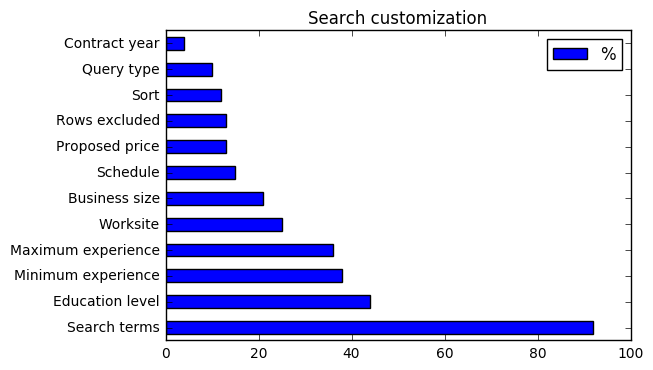

In [4]:
total_rates = rates.shape[0]
percentages = {}

for field, default in FIELD_DEFAULTS.items():
    non_default_rates = rates[rates[field] != default].shape[0]
    percentages[field] = int(non_default_rates / total_rates * 100)

pandas.Series(percentages).to_frame('%').sort_values(by='%', ascending=False)\
  .plot(kind='barh', title="Search customization")

### How many searches had *any* customization, other than search term?

In [5]:
customized = pandas.Series(False, rates.index)
customization_factors = pandas.Series(0, rates.index)

for field, default in FIELD_DEFAULTS.items():
    if field == 'Search terms':
        continue
    field_was_not_default = rates[field] != default
    customized = customized | field_was_not_default
    customization_factors += field_was_not_default.astype(int)

customized_rates = rates[customized]

customized_rates.shape[0] / rates.shape[0]

0.7718368602782811

### Distribution of queries by number of search customizations

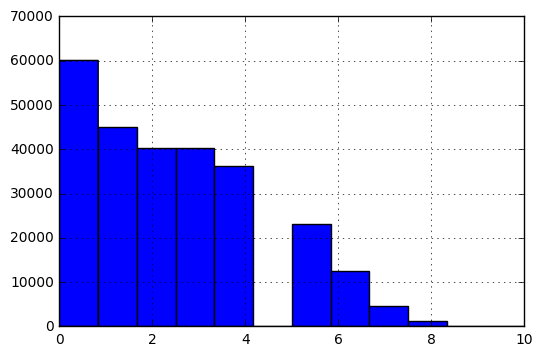

In [6]:
customization_factors.hist(bins=len(FIELD_DEFAULTS))

## Distribution of minimum experience

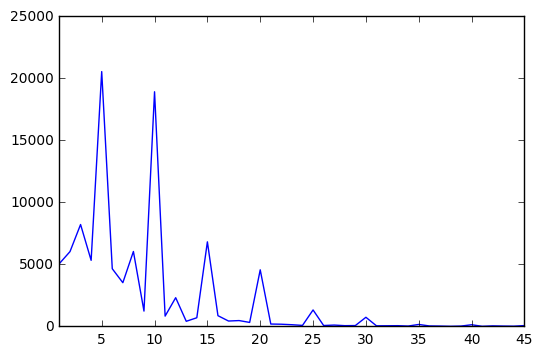

In [7]:
%matplotlib inline

rates[rates['Minimum experience'] > 0]['Minimum experience'].value_counts().sort_index().plot()

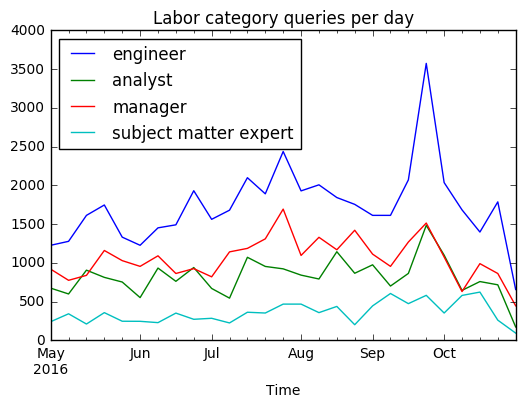

In [8]:
timerates = rates.set_index(['Time'])

r = pandas.DataFrame()

for term in ['engineer', 'analyst', 'manager', 'subject matter expert']:
    r[term] = (timerates['Search terms'].str.contains(term)).astype(int).resample('W').sum()

r.plot(title='Labor category queries per day')

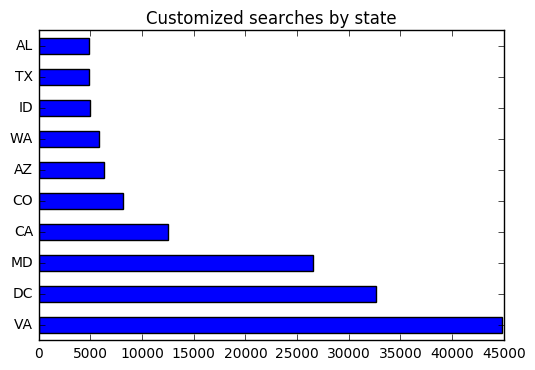

In [9]:
(customized_rates['State'])\
  .value_counts()[:10].plot(kind='barh', title="Customized searches by state")